# Data-Driven Customer Segmentation: A Clustering Approach

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score

## Introduction

Understanding customer behavior is crucial for designing effective marketing strategies. In this project, we apply unsupervised learning techniques—specifically K-means and hierarchical clustering—to uncover natural groupings within customer data. The analysis begins with a clean dataset containing demographic and behavioral features, then extends to a noisy version to test model robustness. By experimenting with feature combinations and normalization, we aim to identify distinct customer segments and explore how gender and noise influence clustering outcomes. The goal is to extract actionable insights that could inform customer targeting and segmentation strategies.

## Data Preprocessing

In [114]:
customers_df = pd.read_csv("customers.csv")

numerical_features = ["Age", "Income", "Score"]

scaler = StandardScaler()
customers_df[numerical_features] = scaler.fit_transform(customers_df[numerical_features])

customers_df.head()

ID  Gender       Age    Income     Score
0   1    Male -1.424569 -1.738999 -0.434801
1   2    Male -1.281035 -1.738999  1.195704
2   3  Female -1.352802 -1.700830 -1.715913
3   4  Female -1.137502 -1.700830  1.040418
4   5  Female -0.563369 -1.662660 -0.395980

First, we load the dataset from `customers.csv`, which contains customer information including Age, Income, and Score. Since these numerical features are on different scales, we apply Z-score normalization to standardize them,so that each feature has a mean of 0 and a standard deviation of 1, preventing any single feature from dominating the clustering process. We use `StandardScaler` from `sklearn.preprocessing` to achieve this normalization. We also display the first few rows of the dataset to verify that the numerical values have been successfully transformed.


## Clustering Analysis

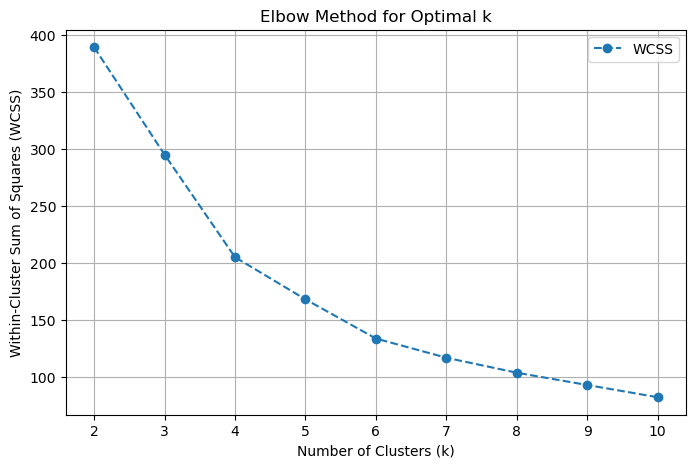

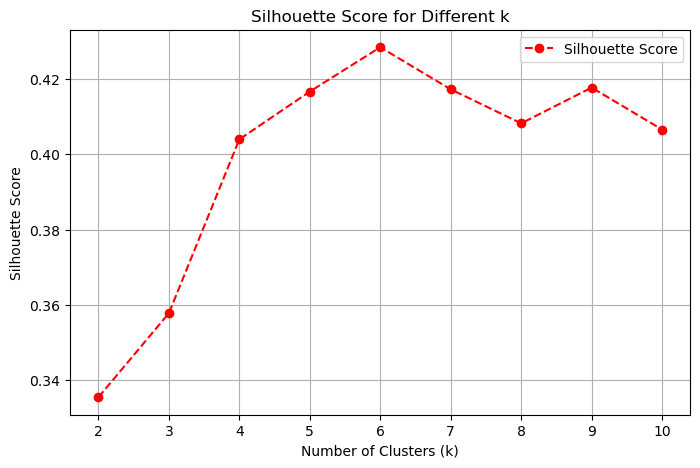

The best value of k based on silhouette score is: 6


In [117]:
X = customers_df[numerical_features]

wcss = []
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)

    wcss.append(kmeans.inertia_)

    if k < len(X):
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    else:
        silhouette_scores.append(float("-inf"))

# Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), wcss, marker="o", linestyle="--", label="WCSS")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method for Optimal k")
plt.legend()
plt.grid(True)
plt.show()

# Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker="o", linestyle="--", color="red", label="Silhouette Score")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different k")
plt.legend()
plt.grid(True)
plt.show()

best_k = range(2, 11)[np.argmax(silhouette_scores)]
print(f"The best value of k based on silhouette score is: {best_k}")

The results from the K-means clustering analysis provide insights into the optimal number of clusters for the dataset. The Elbow Method is used to determine the best $k$ by analyzing the Within-Cluster Sum of Squares (WCSS), which measures how compact the clusters are. WCSS is calculated as:

$$ WCSS = \sum_{i=1}^{k} \sum_{x \in C_i} || x - \mu_i ||^2 $$

where each data point $x$ belongs to cluster $C_i$ with centroid $\mu_i$. The goal is to find the point where adding more clusters no longer significantly reduces WCSS. The plot shows a steep drop in WCSS until $k = 4$, after which the decrease slows down, forming an "elbow" around $k = 4$ or $k = 5$. This suggests that beyond this point, additional clusters provide diminishing improvements in compactness.

The Silhouette Score method evaluates clustering quality by measuring both cohesion and separation. The score for a data point $i$ is given by:

$$ s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))} $$

where $a(i)$ is the average intra-cluster distance and $b(i)$ is the average distance to the nearest cluster. A higher silhouette score indicates well-separated clusters. The silhouette score peaks at $k = 6$, meaning this value results in the most well-defined clustering structure.

Choosing the best $k$ depends on balancing interpretability and performance. While the Elbow Method suggests $k = 4$ or $k = 5$, the Silhouette Score favors $k = 6$. Since a higher silhouette score implies better-defined clusters, $k = 6$ appears to be the optimal choice. Further visualization of the clusters would help confirm if this segmentation is meaningful in practice.



In [119]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
customers_df["Cluster"] = kmeans.fit_predict(customers_df[["Age", "Income", "Score"]])

centroids = kmeans.cluster_centers_

customers_denormalized = customers_df.copy()
customers_denormalized[["Age", "Income", "Score"]] = scaler.inverse_transform(customers_df[["Age", "Income", "Score"]])

centroids_denormalized = scaler.inverse_transform(centroids)
centroids_df = pd.DataFrame(centroids_denormalized, columns=["Age", "Income", "Score"])

fig = px.scatter_3d(customers_denormalized, x="Age", y="Income", z="Score",
                     color=customers_denormalized["Cluster"].astype(str),
                     opacity=0.7, title=f"Customer Clusters with k={best_k}",
                     labels={"Cluster": "Cluster Group"})

fig.add_trace(go.Scatter3d(
    x=centroids_df["Age"],
    y=centroids_df["Income"],
    z=centroids_df["Score"],
    mode="markers",
    marker=dict(size=10, color="black", symbol="x"),
    name="Centroids"
))

fig.update_layout(
    scene=dict(
        xaxis_title="Age",
        yaxis_title="Income",
        zaxis_title="Score"
    ),
    legend_title="Cluster",
    width=1000,
    height=800
)

fig.show(config={"displayModeBar": True, "responsive": True})

The 3D scatter plot visualizes the customer segments formed using K-means clustering with the optimal number of clusters, $k=6$. The data points represent individual customers, with each color indicating a different cluster. The black "X" markers denote the centroids of each cluster, which serve as the central points around which data points are grouped.

The distribution of clusters suggests meaningful segmentation of customers based on Age, Income, and Score. The clusters appear to be well-separated, indicating that K-means effectively identified distinct customer groups. Customers with similar spending scores and income levels tend to be grouped together, with age playing a role in further distinguishing subgroups. Notably, clusters 1 and 0 seem to be the closest in the plot, suggesting that if the number of clusters were set to 5 instead of 6, these two might have merged into a single cluster. This observation aligns with the Elbow Method, where selecting a slightly lower $k$ could lead to broader but less granular segmentation. However, the presence of well-defined centroids confirms that each cluster has a distinct center, reinforcing the validity of the chosen segmentation.

By examining the cluster placements, we can interpret potential customer profiles. For instance, one cluster might represent younger customers with high spending scores and moderately high income (cluster 3), while another might include older customers with low spending scores and low income levels (cluster 5). The plot suggests that income and spending behavior are key factors in segmentation, possibly indicating different customer preferences or purchasing power.

Further analysis could explore whether these segments align with real-world business insights, such as marketing strategies or product recommendations. Additionally, incorporating categorical features like gender could refine the clustering results and enhance customer profiling.


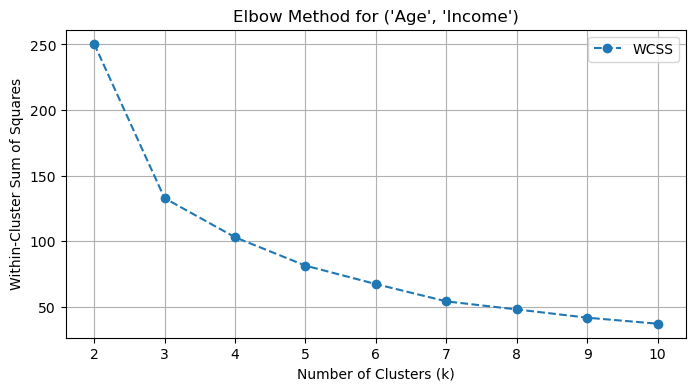

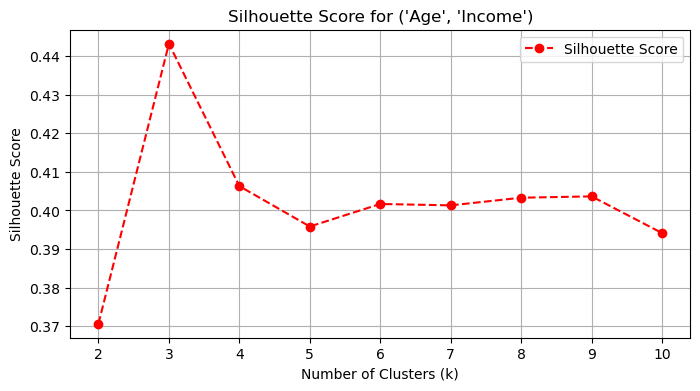

Best k for ('Age', 'Income'): 3


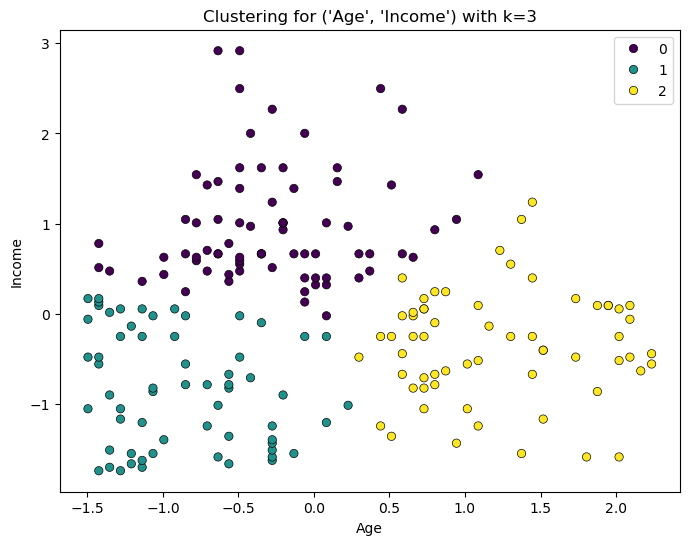

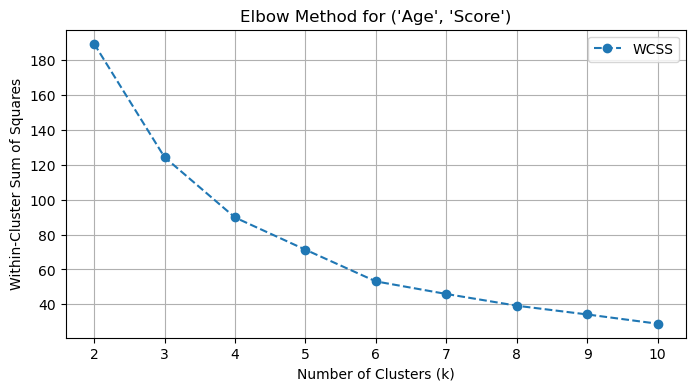

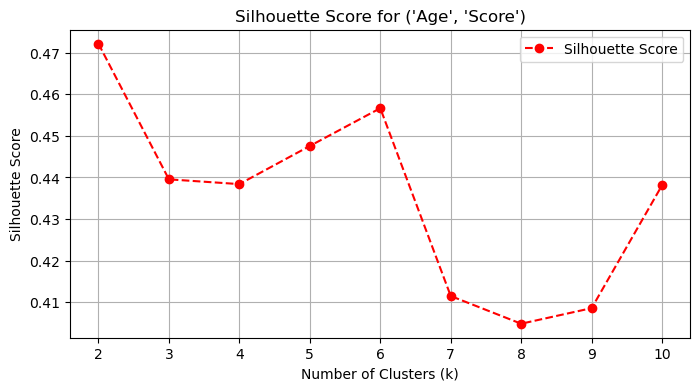

Best k for ('Age', 'Score'): 2


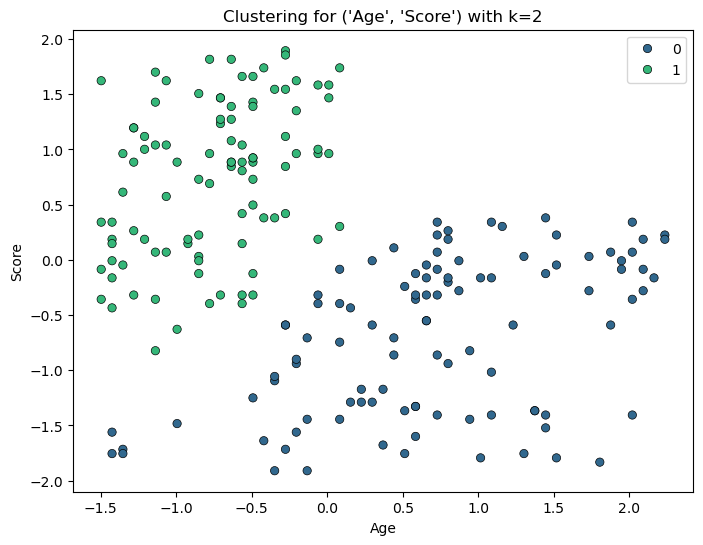

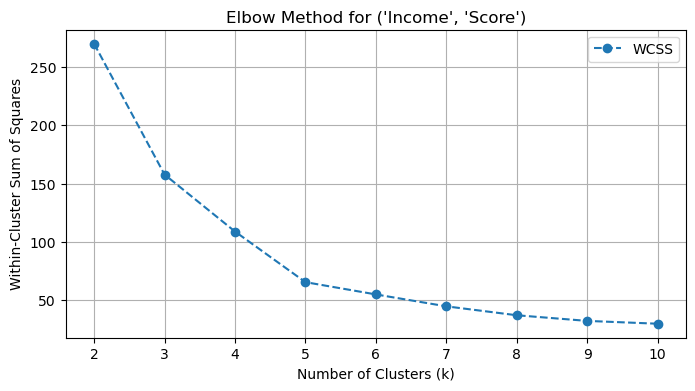

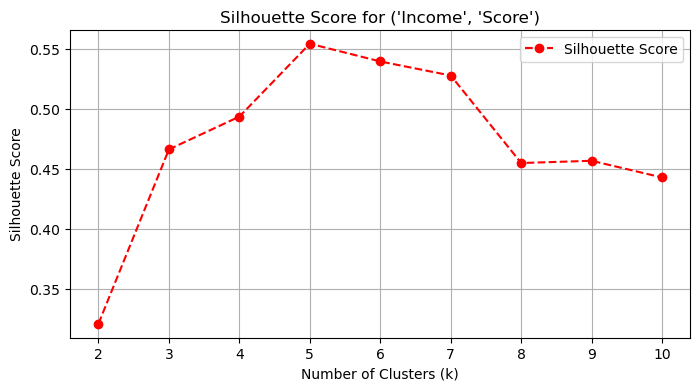

Best k for ('Income', 'Score'): 5


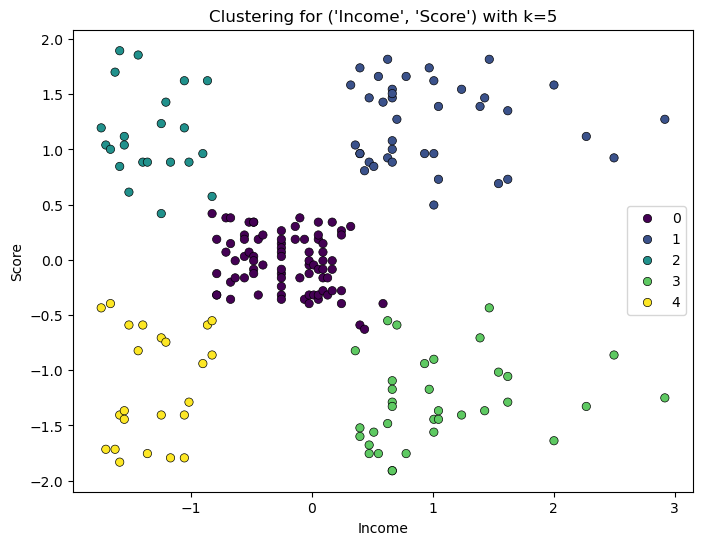

Feature Pair  Best k
0    (Age, Income)       3
1     (Age, Score)       2
2  (Income, Score)       5

In [121]:
feature_pairs = [("Age", "Income"), ("Age", "Score"), ("Income", "Score")]

best_k_values = {}

for features in feature_pairs:
    X_subset = customers_df[list(features)]
    wcss = []
    silhouette_scores = []

    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_subset)

        wcss.append(kmeans.inertia_)

        if k < len(X_subset):
            silhouette_scores.append(silhouette_score(X_subset, kmeans.labels_))
        else:
            silhouette_scores.append(float("-inf"))

    best_k = range(2, 11)[np.argmax(silhouette_scores)]
    best_k_values[features] = best_k

    # Elbow Method (WCSS)
    plt.figure(figsize=(8, 4))
    plt.plot(range(2, 11), wcss, marker="o", linestyle="--", label="WCSS")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Within-Cluster Sum of Squares")
    plt.title(f"Elbow Method for {features}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Silhouette Scores
    plt.figure(figsize=(8, 4))
    plt.plot(range(2, 11), silhouette_scores, marker="o", linestyle="--", color="red", label="Silhouette Score")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title(f"Silhouette Score for {features}")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Best k for {features}: {best_k}")

    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    customers_df[f'Cluster_{features}'] = kmeans.fit_predict(customers_df[list(features)])

    plt.figure(figsize=(8,6))
    sns.scatterplot(
        x=customers_df[features[0]], y=customers_df[features[1]],
        hue=customers_df[f'Cluster_{features}'], palette='viridis', edgecolor='k'
    )
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title(f'Clustering for {features} with k={best_k}')
    plt.legend()
    plt.show()

best_k_df = pd.DataFrame(list(best_k_values.items()), columns=["Feature Pair", "Best k"])
best_k_df

The results show the optimal number of clusters for three different feature pairs: (Age, Income), (Age, Score), and (Income, Score). The Elbow Method and Silhouette Score were used to determine the best $k$ for each case.

For **(Age, Income)**, the Elbow Method suggests $k=3$ as the WCSS curve shows a noticeable drop before flattening. The Silhouette Score also peaks at $k=3$, confirming that this is the most well-defined clustering structure for these features. This indicates that grouping customers based on age and income results in three meaningful clusters, possibly distinguishing low, middle, and high-income groups across different age ranges.

For **(Age, Score)**, the Elbow Method does not show a very clear "elbow," but the Silhouette Score peaks at $k=2$, suggesting that a two-cluster model provides the best-defined segmentation. This implies that customer behavior in terms of age and spending score may naturally divide into two broad categories, potentially indicating low and high spenders.

For **(Income, Score)**, the Elbow Method suggests that $k=5$ may be a reasonable choice, while the Silhouette Score also peaks around $k=5$. This suggests that segmenting customers based on income and spending behavior leads to more fine-grained clusters, likely separating different levels of financial engagement and spending habits.

The results highlight how different feature combinations influence cluster formation. The choice of features affects how customer segments are identified, with some attributes (e.g., income and spending score) providing more nuanced groupings than others.



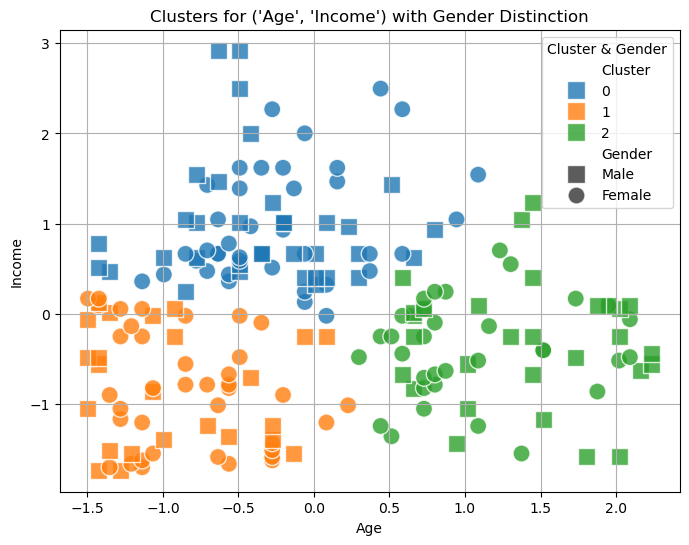

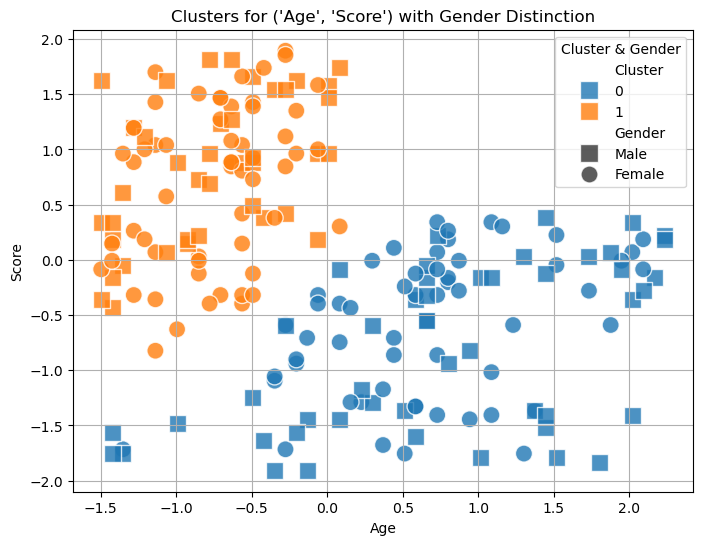

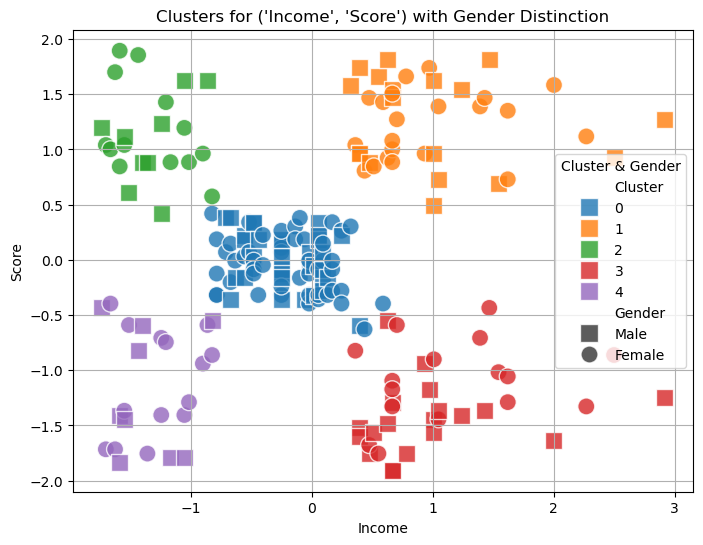

In [123]:
for features in feature_pairs:
    X_subset = customers_df[list(features)]

    best_k = best_k_values[features]
    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    customers_df["Cluster"] = kmeans.fit_predict(X_subset)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=customers_df[features[0]],
                    y=customers_df[features[1]],
                    hue=customers_df["Cluster"],
                    style=customers_df["Gender"],
                    palette="tab10",
                    markers={"Female": "o", "Male": "s"},  # More explicit marker mapping
                    s=150,  # Increase marker size for better visibility
                    alpha=0.8)

    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title(f"Clusters for {features} with Gender Distinction")
    plt.legend(title="Cluster & Gender")
    plt.grid(True)
    plt.show()

When we compared our original cluster plots, which only considered numerical features like Age, Income, and Score, to the new ones that also highlight Gender, we noticed certain subgroups we hadn’t identified before. In particular, the additional markers for Male and Female revealed that some clusters, which appeared uniform in the purely numeric plots, actually contain smaller pockets distinguished by gender. These subtle differences might prove crucial if our analysis depends on tailoring strategies or services according to gender-specific preferences.

As for whether it’s worth encoding Gender as a binary variable and including it in K-means, we believe it depends on the purpose of our segmentation. If gender-based distinctions align with meaningful behavioural or purchasing patterns, then including Gender can enhance our insights. However, if these distinctions do not lead to actionable differences, then adding Gender might introduce unnecessary complexity.

Next, we load the `customers_noisy` dataset, which includes the original four features (with ‘Gender’ now encoded as a binary variable) along with four additional noisy features. We then perform hierarchical clustering on the full set of features to uncover deeper insights despite the presence of noise.

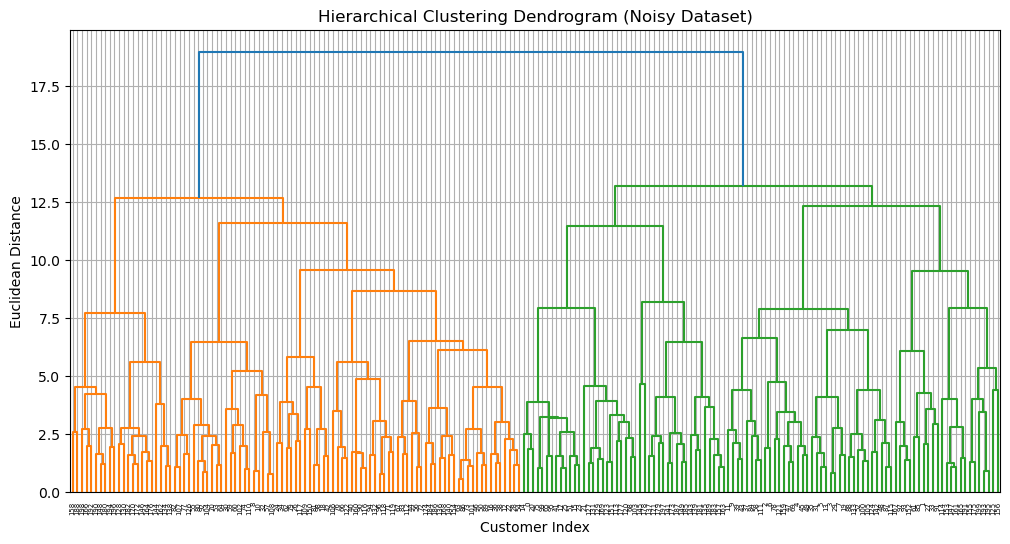

In [125]:
customers_noisy_df = pd.read_csv("customers_noisy.csv")

X_noisy = customers_noisy_df.iloc[:, :]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_noisy)

linked = linkage(X_scaled, method="ward")

plt.figure(figsize=(12, 6))
dendrogram(linked, orientation="top", distance_sort="ascending", show_leaf_counts=True)
plt.title("Hierarchical Clustering Dendrogram (Noisy Dataset)")
plt.xlabel("Customer Index")
plt.ylabel("Euclidean Distance")
plt.grid(True)
plt.show()

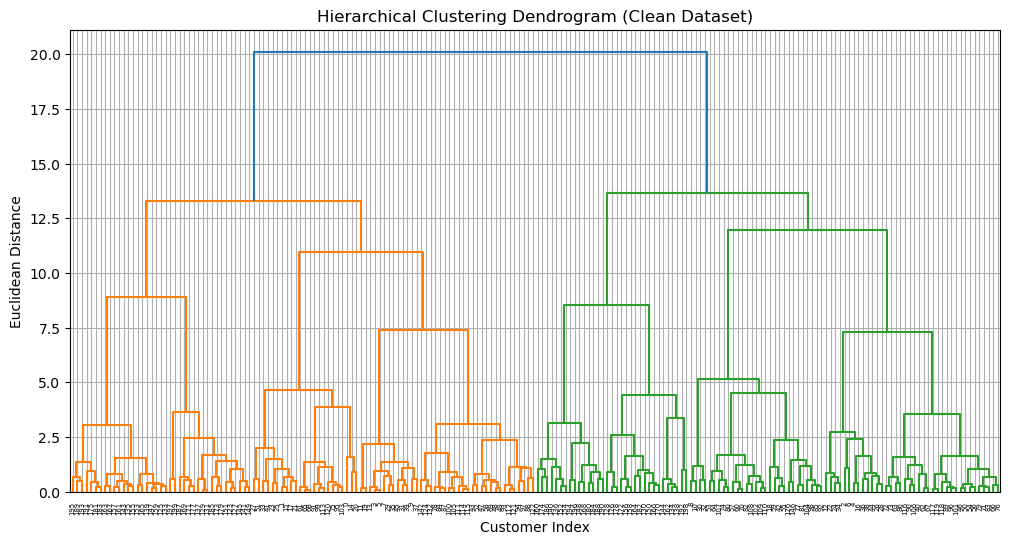

In [126]:
customers_df = pd.read_csv("customers.csv")

df_for_clustering = customers_df.drop(columns=["ID"]).copy()
df_for_clustering["Gender"] = df_for_clustering["Gender"].map({"Male": 0, "Female": 1})

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_for_clustering)

linked = linkage(X_scaled, method="ward")

plt.figure(figsize=(12, 6))
dendrogram(linked, orientation="top", distance_sort="ascending", show_leaf_counts=True)
plt.title("Hierarchical Clustering Dendrogram (Clean Dataset)")
plt.xlabel("Customer Index")
plt.ylabel("Euclidean Distance")
plt.grid(True)
plt.show()

Both dendrograms reveal two main clusters at a relatively high distance, but the clean dataset’s dendrogram exhibits more distinct subclusters with clearer boundaries. In contrast, the noisy dataset’s dendrogram is somewhat more scattered, as the extra irrelevant features obscure the natural separations and cause certain points to merge at unexpected distances.

Overall, while both datasets suggest a fundamental split into two broad groups, the clean dataset allows for a clearer view of customer segmentation, reflecting the stronger relevance of its features. The noisy data makes it more difficult to discern crisp subclusters, indicating the importance of careful feature selection when performing hierarchical clustering.

## Conclusion

Through K-means and hierarchical clustering, we identified meaningful customer segments based on age, income, and spending score. Visualizations revealed distinct clusters that were often aligned with demographic features like gender, helping to uncover consumer subgroups with similar behaviors. Testing different feature combinations highlighted which attributes contributed most to cluster formation. Despite the addition of noise in the extended dataset, hierarchical clustering still revealed structure, demonstrating the robustness of clustering methods in noisy environments. These findings provide valuable guidance for targeted marketing and customer segmentation strategies.